# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.manifold import spectral_embedding
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

# Helpers

In [2]:
def get_and_scale_mnist_data(train_file_path, test_file_path, n_samples):

  # get train-val data
  train_val_df = pd.read_csv(train_file_path, header=0)
  X_train_val = train_val_df.iloc[:n_samples, 1:].to_numpy()
  y_train_val = train_val_df.iloc[:n_samples, 0].to_numpy()

  # get test data
  test_df = pd.read_csv(test_file_path, header=0)
  X_test = test_df.iloc[:, 1:].to_numpy()
  y_test = test_df.iloc[:, 0].to_numpy()

  # scale data
  scaler = MinMaxScaler()
  X_train_val = scaler.fit_transform(X_train_val)
  X_test = scaler.transform(X_test)

  print(X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape)

  return X_train_val, X_test, y_train_val, y_test

In [3]:
class MySpectralPlusKMeans():

  def __init__(self, 
               neighbors_mode='connectivity', 
               neighbors_include_self=True,
               spectral_norm_laplacian=False, 
               spectral_drop_first=False,
               random_state=0, 
               max_iter=1000):
    
    self.neighbors_mode = neighbors_mode
    self.neighbors_include_self = neighbors_include_self
    self.spectral_norm_laplacian = spectral_norm_laplacian
    self.spectral_drop_first = spectral_drop_first
    self.random_state = random_state
    self.max_iter = max_iter

  def fit_transform(self, X, n_neighbors=50, spectral_components=8):
    print("Spectral Clustering --> fit+trasform ...")
    self.n_neighbors = n_neighbors
    self.spectral_components = spectral_components
    tic = time.time()
    self.KN = kneighbors_graph(X, 
                               n_neighbors=self.n_neighbors, 
                               mode=self.neighbors_mode, 
                               include_self=self.neighbors_include_self)
    
    self.V = spectral_embedding(self.KN, 
                                n_components=self.spectral_components, 
                                norm_laplacian=self.spectral_norm_laplacian, 
                                drop_first=self.spectral_drop_first)
    self.dt_spectral= time.time() - tic
    return self.V, self.dt_spectral
  
  def plot_eigvals(self, train_or_test_str='Train'):
    similarity_matrix = (self.KN + self.KN.T)/2
    D = sparse.diags(np.array(sparse.csr_matrix.sum(similarity_matrix, axis=1)).flatten(), offsets=0)
    self.L = D - similarity_matrix

    eigvals = list()
    for n in range(self.spectral_components):
      v = self.V[:, n]
      lambda_v = sparse.csr_matrix.dot(self.L, v)
      eigval = np.divide(lambda_v, v)[0]
      eigvals.append(eigval)

    plt.figure(figsize=(30, 10))
    plt.plot(np.array(eigvals), "*")
    plt.title(f"Eigenvalues ({train_or_test_str} set)")
    plt.xlabel("Number of eigenvalue")
    plt.ylabel("Eigenvalue")
    plt.show()

  def fit_kmeans(self, X, n_clusters=10):
    self.n_clusters = n_clusters
    tic = time.time()
    self.k_means = KMeans(n_clusters=self.n_clusters, 
                          random_state=self.random_state, 
                          max_iter=self.max_iter)
    self.k_means.fit(X[:, 1:])
    self.dt_kmeans = time.time() - tic
    return self.dt_kmeans
  
  def predict(self, X):
    self.y_preds = self.k_means.predict(X[:, 1:])
    return self.y_preds

  def get_results(self, X, y):
    self.p_list = list()
    for true_class in range(self.n_clusters):
      y_preds_c = self.k_means.predict(X[:, 1:][y == true_class])
      s = pd.Series(y_preds_c).value_counts()
      p = float("{:.2f}".format(100 * s.max() / s.sum()))
      self.p_list.append(p)
      print(f"True Class: {true_class} --> {p}%")
    self.p_mean = np.array(self.p_list).mean()
    print("==============================")
    print(f"Mean percentage = {self.p_mean}%")
    print("==============================")

    return self.p_mean

# MAIN

## Read data

In [4]:
TRAIN_FILE_PATH = '/content/mnist_train.csv'
TEST_FILE_PATH = '/content/mnist_test.csv'
N_SAMPLES = 50000
tSNE_components = 2

# Get data
X_train, X_test, y_train, y_test = get_and_scale_mnist_data(TRAIN_FILE_PATH, 
                                                            TEST_FILE_PATH, 
                                                            N_SAMPLES)

(50000, 784) (9999, 784) (50000,) (9999,)


## t-SNE

In [5]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

# dimensionality reduction tSNE
tSNE = TSNE(n_components=tSNE_components)
X_tsne = tSNE.fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


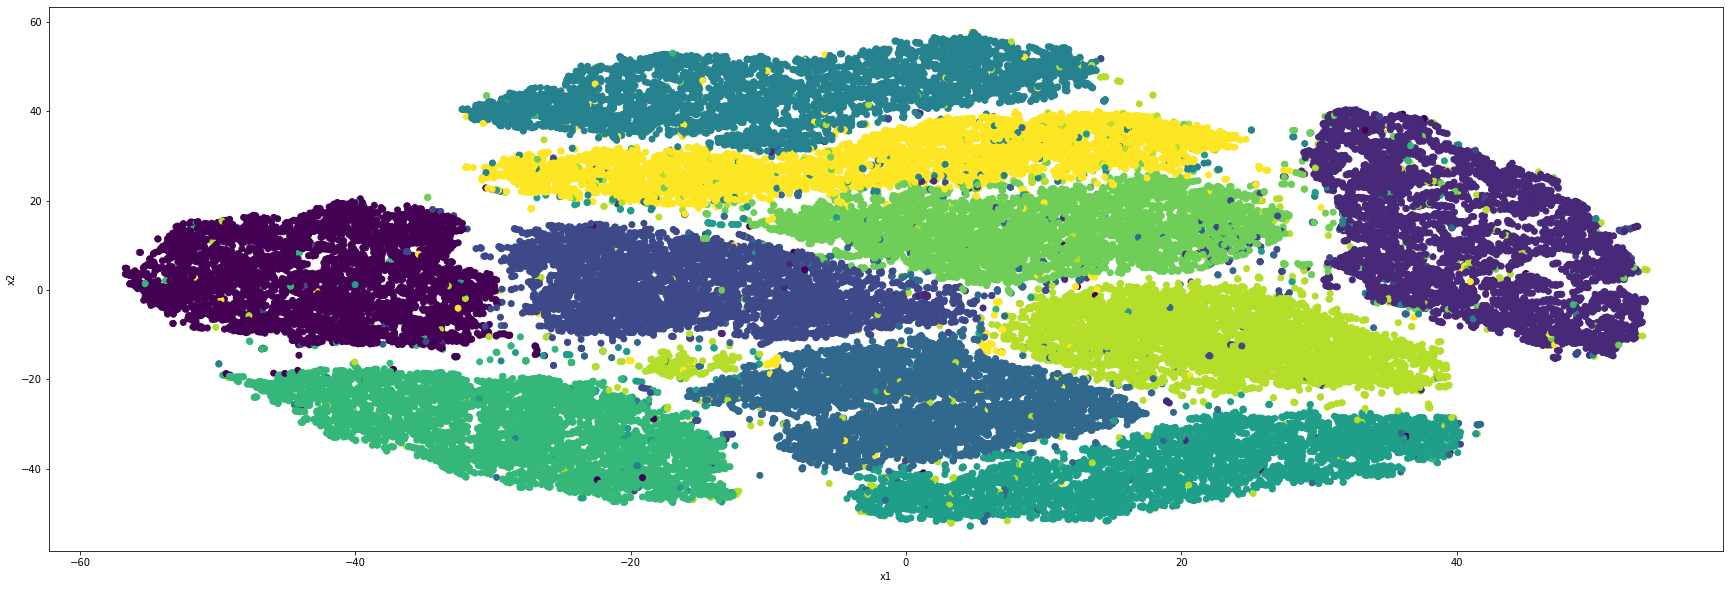

In [6]:
# plot tSNE
plt.figure(figsize=(30, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [7]:
X_train_tsne = X_tsne[:X_train.shape[0], :]
X_test_tsne = X_tsne[X_train.shape[0]:, :]
print(X_train_tsne.shape, X_test_tsne.shape)

(50000, 2) (9999, 2)


In [8]:
n_clusters = 10
k_means = KMeans(n_clusters=n_clusters, random_state=0, max_iter=1000)
k_means.fit(X_train_tsne)
y_preds = k_means.predict(X_test_tsne)

In [9]:
p_list = list()
for true_class in range(10):
  y_preds_c = k_means.predict(X_test_tsne[y_test == true_class])
  s = pd.Series(y_preds_c).value_counts()
  p = float("{:.2f}".format(100 * s.max() / s.sum()))
  p_list.append(p)
  print(f"True Class: {true_class} --> {p}%")
p_mean = np.array(p_list).mean()
print("==============================")
print(f"Mean percentage = {p_mean}%")
print("==============================")

True Class: 0 --> 99.18%
True Class: 1 --> 62.47%
True Class: 2 --> 93.41%
True Class: 3 --> 94.65%
True Class: 4 --> 58.66%
True Class: 5 --> 82.17%
True Class: 6 --> 98.54%
True Class: 7 --> 86.56%
True Class: 8 --> 70.02%
True Class: 9 --> 49.65%
Mean percentage = 79.531%


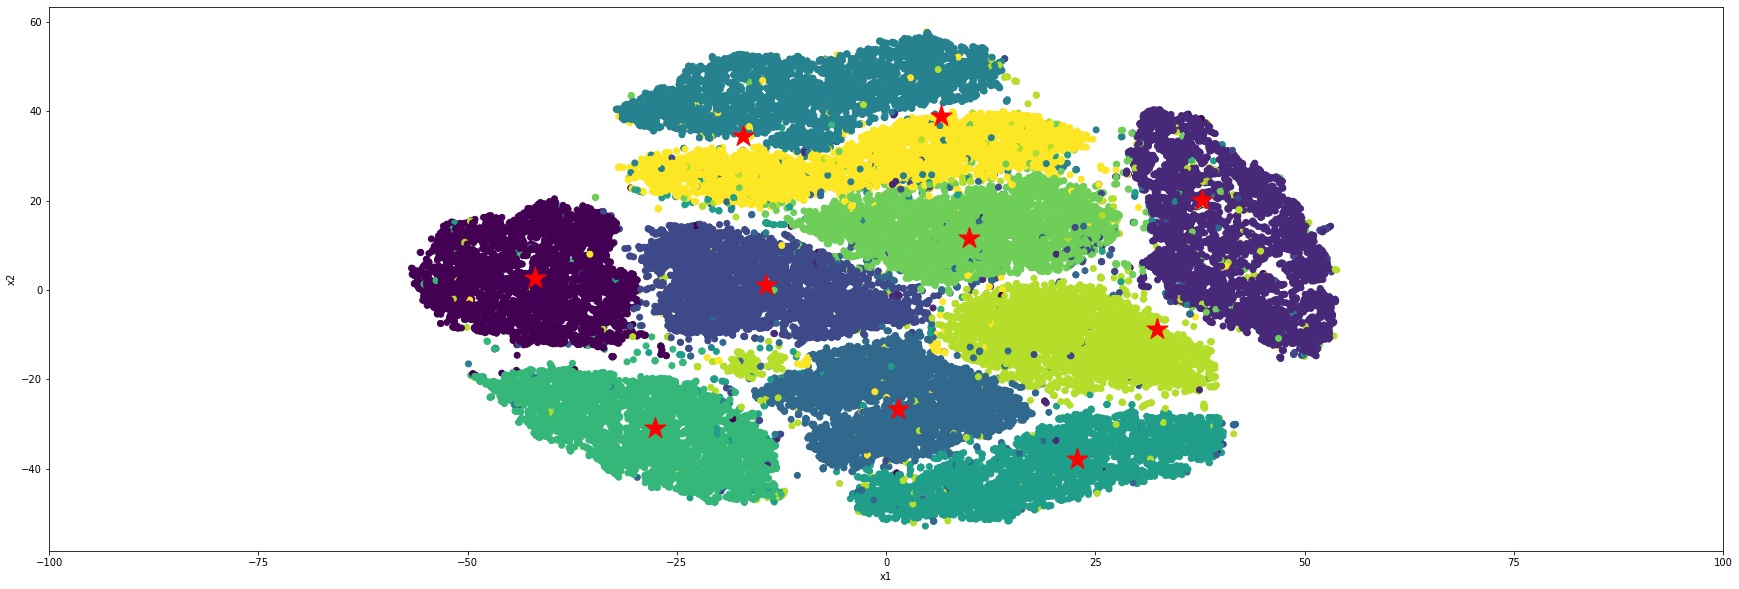

In [10]:
# plot tSNE (Train)
plt.figure(figsize=(30, 10))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train)
plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], c="r", marker="*", s=500)
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim([-100, 100])
plt.show()

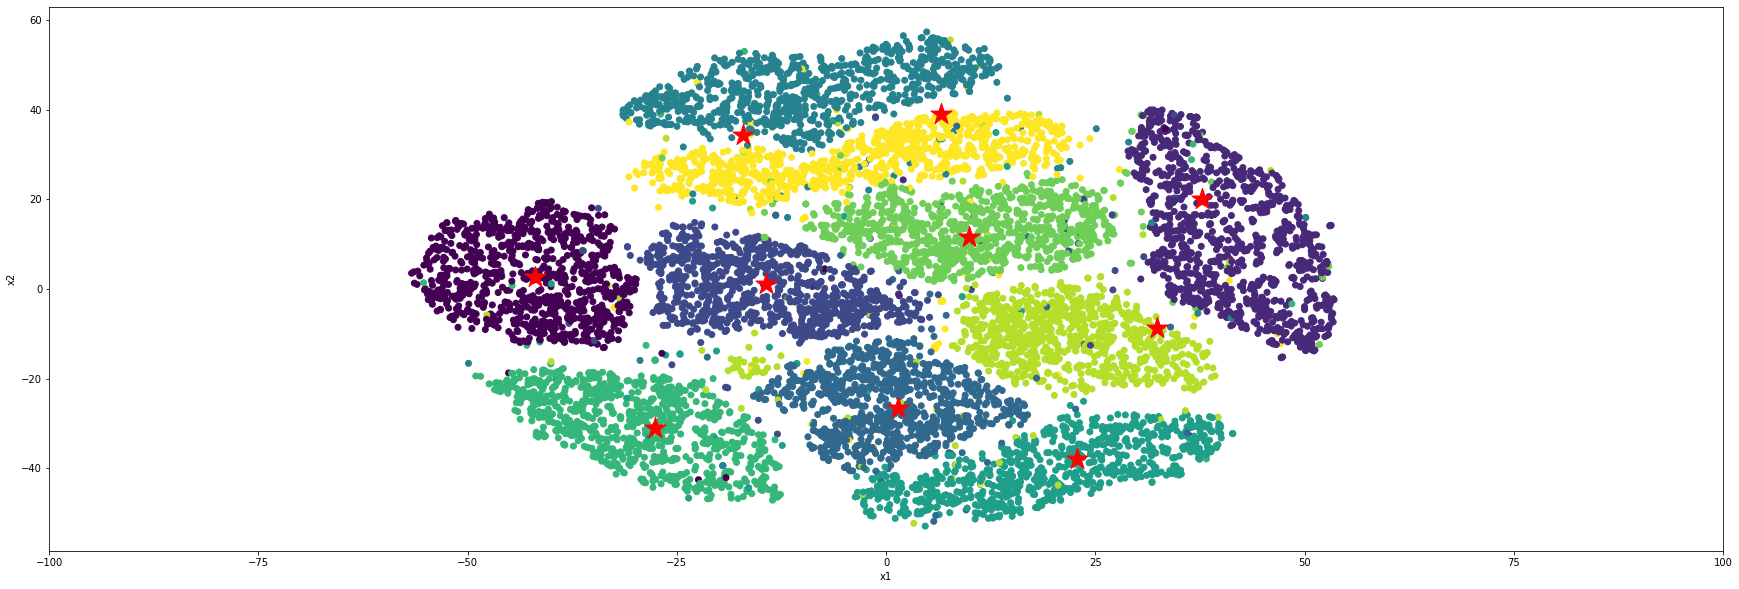

In [11]:
# plot tSNE (Test)
plt.figure(figsize=(30, 10))
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test)
plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], c="r", marker="*", s=500)
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim([-100, 100])
plt.show()

## Spectral Clustering + K-Means

In [12]:
n_neighbors_list = [12, 25, 50, 100, 200, 300, 400, 500, 600, 700]
sc_start, sc_stop, sc_step = 3, 100, 1
spectral_components_list = np.arange(sc_start, sc_stop, sc_step)
n_clusters = 10
dt_spectral_train_lisτ = list()
dt_spectral_list, dt_kmeans_list, p_mean_list = list(), list(), list()
for n_neighbors in n_neighbors_list: 
  print(f"\n==================== n_neighbors={n_neighbors} ====================")
  sc_plus_kmeans = MySpectralPlusKMeans()
  V, dt_spectral = sc_plus_kmeans.fit_transform(X_tsne, 
                                                n_neighbors=n_neighbors, 
                                                spectral_components=sc_stop)
  dt_spectral_list.append(dt_spectral)
  for spectral_components in spectral_components_list:
    print(f"\n******* spectral_components={spectral_components} *******")
    V_kmeans_train = V[:X_train.shape[0], :spectral_components]
    V_kmeans_test = V[X_train.shape[0]:, :spectral_components]

    dt_kmeans = sc_plus_kmeans.fit_kmeans(V_kmeans_train, n_clusters=n_clusters)
    dt_kmeans_list.append(dt_kmeans)
    y_preds = sc_plus_kmeans.predict(V_kmeans_test)
    p_mean = sc_plus_kmeans.get_results(V_kmeans_test, y_test)
    p_mean_list.append(p_mean)


==================== n_neighbors=12 ====================
Spectral Clustering --> fit+trasform ...


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



******* spectral_components=3 *******
True Class: 0 --> 98.67%
True Class: 1 --> 56.12%
True Class: 2 --> 62.79%
True Class: 3 --> 49.5%
True Class: 4 --> 93.18%
True Class: 5 --> 46.97%
True Class: 6 --> 98.23%
True Class: 7 --> 63.39%
True Class: 8 --> 83.06%
True Class: 9 --> 85.73%
Mean percentage = 73.76399999999998%

******* spectral_components=4 *******
True Class: 0 --> 98.78%
True Class: 1 --> 99.21%
True Class: 2 --> 57.07%
True Class: 3 --> 92.87%
True Class: 4 --> 95.82%
True Class: 5 --> 95.96%
True Class: 6 --> 98.23%
True Class: 7 --> 90.94%
True Class: 8 --> 91.99%
True Class: 9 --> 94.75%
Mean percentage = 91.562%

******* spectral_components=5 *******
True Class: 0 --> 98.98%
True Class: 1 --> 99.21%
True Class: 2 --> 91.76%
True Class: 3 --> 94.65%
True Class: 4 --> 95.62%
True Class: 5 --> 97.2%
True Class: 6 --> 98.23%
True Class: 7 --> 83.93%
True Class: 8 --> 91.58%
True Class: 9 --> 93.76%
Mean percentage = 94.492%

******* spectral_components=6 *******
True Cl

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 91.86%
True Class: 3 --> 95.15%
True Class: 4 --> 95.72%
True Class: 5 --> 96.3%
True Class: 6 --> 98.23%
True Class: 7 --> 81.69%
True Class: 8 --> 91.68%
True Class: 9 --> 93.76%
Mean percentage = 94.31300000000002%

******* spectral_components=4 *******
True Class: 0 --> 98.98%
True Class: 1 --> 99.56%
True Class: 2 --> 90.79%
True Class: 3 --> 94.85%
True Class: 4 --> 95.62%
True Class: 5 --> 95.96%
True Class: 6 --> 98.23%
True Class: 7 --> 83.64%
True Class: 8 --> 91.68%
True Class: 9 --> 93.76%
Mean percentage = 94.30699999999999%

******* spectral_components=5 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.47%
True Class: 2 --> 93.51%
True Class: 3 --> 93.76%
True Class: 4 --> 95.62%
True Class: 5 --> 96.52%
True Class: 6 --> 98.23%
True Class: 7 --> 81.6%
True Class: 8 --> 90.25%
True Class: 9 --> 92.17%
Mean percentage = 94.03099999999999%

******* spectral_compon

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 93.02%
True Class: 3 --> 94.75%
True Class: 4 --> 94.7%
True Class: 5 --> 96.52%
True Class: 6 --> 98.75%
True Class: 7 --> 86.76%
True Class: 8 --> 91.99%
True Class: 9 --> 94.25%
Mean percentage = 94.94800000000001%

******* spectral_components=4 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 94.96%
True Class: 3 --> 91.09%
True Class: 4 --> 95.52%
True Class: 5 --> 96.52%
True Class: 6 --> 98.75%
True Class: 7 --> 83.15%
True Class: 8 --> 90.55%
True Class: 9 --> 92.07%
Mean percentage = 94.13499999999999%

******* spectral_components=5 *******
True Class: 0 --> 98.16%
True Class: 1 --> 99.56%
True Class: 2 --> 94.96%
True Class: 3 --> 93.76%
True Class: 4 --> 95.52%
True Class: 5 --> 96.52%
True Class: 6 --> 98.23%
True Class: 7 --> 82.47%
True Class: 8 --> 90.97%
True Class: 9 --> 92.07%
Mean percentage = 94.22200000000001%

******* spectral_compo

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 95.54%
True Class: 3 --> 94.65%
True Class: 4 --> 95.32%
True Class: 5 --> 96.64%
True Class: 6 --> 98.75%
True Class: 7 --> 90.36%
True Class: 8 --> 91.99%
True Class: 9 --> 94.05%
Mean percentage = 95.604%

******* spectral_components=4 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 95.64%
True Class: 3 --> 92.57%
True Class: 4 --> 95.52%
True Class: 5 --> 96.52%
True Class: 6 --> 98.75%
True Class: 7 --> 88.32%
True Class: 8 --> 91.07%
True Class: 9 --> 93.36%
Mean percentage = 95.04899999999999%

******* spectral_components=5 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 95.64%
True Class: 3 --> 94.85%
True Class: 4 --> 95.52%
True Class: 5 --> 96.52%
True Class: 6 --> 98.23%
True Class: 7 --> 88.61%
True Class: 8 --> 91.38%
True Class: 9 --> 93.36%
Mean percentage = 95.285%

******* spectral_components=6 *******
True 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 95.83%
True Class: 3 --> 72.97%
True Class: 4 --> 95.52%
True Class: 5 --> 96.86%
True Class: 6 --> 98.64%
True Class: 7 --> 90.36%
True Class: 8 --> 91.99%
True Class: 9 --> 93.95%
Mean percentage = 93.48600000000002%

******* spectral_components=4 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 95.35%
True Class: 3 --> 90.79%
True Class: 4 --> 95.72%
True Class: 5 --> 96.64%
True Class: 6 --> 98.64%
True Class: 7 --> 89.78%
True Class: 8 --> 91.07%
True Class: 9 --> 93.66%
Mean percentage = 95.039%

******* spectral_components=5 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 95.45%
True Class: 3 --> 93.96%
True Class: 4 --> 95.52%
True Class: 5 --> 96.64%
True Class: 6 --> 98.64%
True Class: 7 --> 90.56%
True Class: 8 --> 91.68%
True Class: 9 --> 93.86%
Mean percentage = 95.50500000000001%

******* spectral_components=6 **

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 95.54%
True Class: 3 --> 65.05%
True Class: 4 --> 96.03%
True Class: 5 --> 96.86%
True Class: 6 --> 98.64%
True Class: 7 --> 90.07%
True Class: 8 --> 91.99%
True Class: 9 --> 93.86%
Mean percentage = 92.67800000000001%

******* spectral_components=4 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 95.35%
True Class: 3 --> 89.6%
True Class: 4 --> 96.13%
True Class: 5 --> 96.64%
True Class: 6 --> 98.64%
True Class: 7 --> 89.68%
True Class: 8 --> 90.55%
True Class: 9 --> 93.46%
Mean percentage = 94.87899999999999%

******* spectral_components=5 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 95.25%
True Class: 3 --> 92.67%
True Class: 4 --> 95.93%
True Class: 5 --> 96.64%
True Class: 6 --> 98.64%
True Class: 7 --> 90.46%
True Class: 8 --> 91.58%
True Class: 9 --> 93.56%
Mean percentage = 95.34700000000001%

******* spectral_compo

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 94.86%
True Class: 3 --> 70.69%
True Class: 4 --> 96.03%
True Class: 5 --> 96.86%
True Class: 6 --> 98.64%
True Class: 7 --> 90.17%
True Class: 8 --> 91.99%
True Class: 9 --> 93.16%
Mean percentage = 93.114%

******* spectral_components=4 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 95.16%
True Class: 3 --> 89.6%
True Class: 4 --> 96.03%
True Class: 5 --> 96.75%
True Class: 6 --> 98.64%
True Class: 7 --> 89.58%
True Class: 8 --> 90.25%
True Class: 9 --> 92.96%
Mean percentage = 94.771%

******* spectral_components=5 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 94.77%
True Class: 3 --> 91.58%
True Class: 4 --> 95.93%
True Class: 5 --> 96.75%
True Class: 6 --> 98.64%
True Class: 7 --> 90.46%
True Class: 8 --> 91.58%
True Class: 9 --> 93.46%
Mean percentage = 95.191%

******* spectral_components=6 *******
True Class: 0 -->

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 94.19%
True Class: 3 --> 71.88%
True Class: 4 --> 96.54%
True Class: 5 --> 96.86%
True Class: 6 --> 98.64%
True Class: 7 --> 88.51%
True Class: 8 --> 91.99%
True Class: 9 --> 70.37%
Mean percentage = 90.772%

******* spectral_components=4 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 94.38%
True Class: 3 --> 89.21%
True Class: 4 --> 96.13%
True Class: 5 --> 96.75%
True Class: 6 --> 98.64%
True Class: 7 --> 89.48%
True Class: 8 --> 90.25%
True Class: 9 --> 92.57%
Mean percentage = 94.61499999999998%

******* spectral_components=5 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 94.48%
True Class: 3 --> 92.18%
True Class: 4 --> 95.93%
True Class: 5 --> 96.75%
True Class: 6 --> 98.64%
True Class: 7 --> 90.65%
True Class: 8 --> 91.68%
True Class: 9 --> 92.86%
Mean percentage = 95.19100000000002%

******* spectral_components=6 **

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 93.8%
True Class: 3 --> 74.06%
True Class: 4 --> 96.54%
True Class: 5 --> 96.86%
True Class: 6 --> 98.64%
True Class: 7 --> 88.12%
True Class: 8 --> 91.89%
True Class: 9 --> 65.31%
Mean percentage = 90.396%

******* spectral_components=4 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 94.48%
True Class: 3 --> 90.3%
True Class: 4 --> 96.13%
True Class: 5 --> 96.75%
True Class: 6 --> 98.64%
True Class: 7 --> 89.68%
True Class: 8 --> 90.25%
True Class: 9 --> 91.58%
Mean percentage = 94.655%

******* spectral_components=5 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 94.38%
True Class: 3 --> 92.48%
True Class: 4 --> 95.93%
True Class: 5 --> 96.64%
True Class: 6 --> 98.64%
True Class: 7 --> 90.65%
True Class: 8 --> 91.89%
True Class: 9 --> 92.77%
Mean percentage = 95.212%

******* spectral_components=6 *******
True Class: 0 --> 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 93.8%
True Class: 3 --> 81.49%
True Class: 4 --> 96.54%
True Class: 5 --> 96.86%
True Class: 6 --> 98.64%
True Class: 7 --> 78.38%
True Class: 8 --> 91.89%
True Class: 9 --> 53.32%
Mean percentage = 88.966%

******* spectral_components=4 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 94.48%
True Class: 3 --> 90.4%
True Class: 4 --> 95.93%
True Class: 5 --> 96.75%
True Class: 6 --> 98.64%
True Class: 7 --> 89.39%
True Class: 8 --> 90.25%
True Class: 9 --> 90.29%
Mean percentage = 94.487%

******* spectral_components=5 *******
True Class: 0 --> 99.18%
True Class: 1 --> 99.56%
True Class: 2 --> 94.38%
True Class: 3 --> 91.68%
True Class: 4 --> 95.82%
True Class: 5 --> 96.64%
True Class: 6 --> 98.64%
True Class: 7 --> 89.87%
True Class: 8 --> 91.99%
True Class: 9 --> 92.27%
Mean percentage = 95.003%

******* spectral_components=6 *******
True Class: 0 --> 

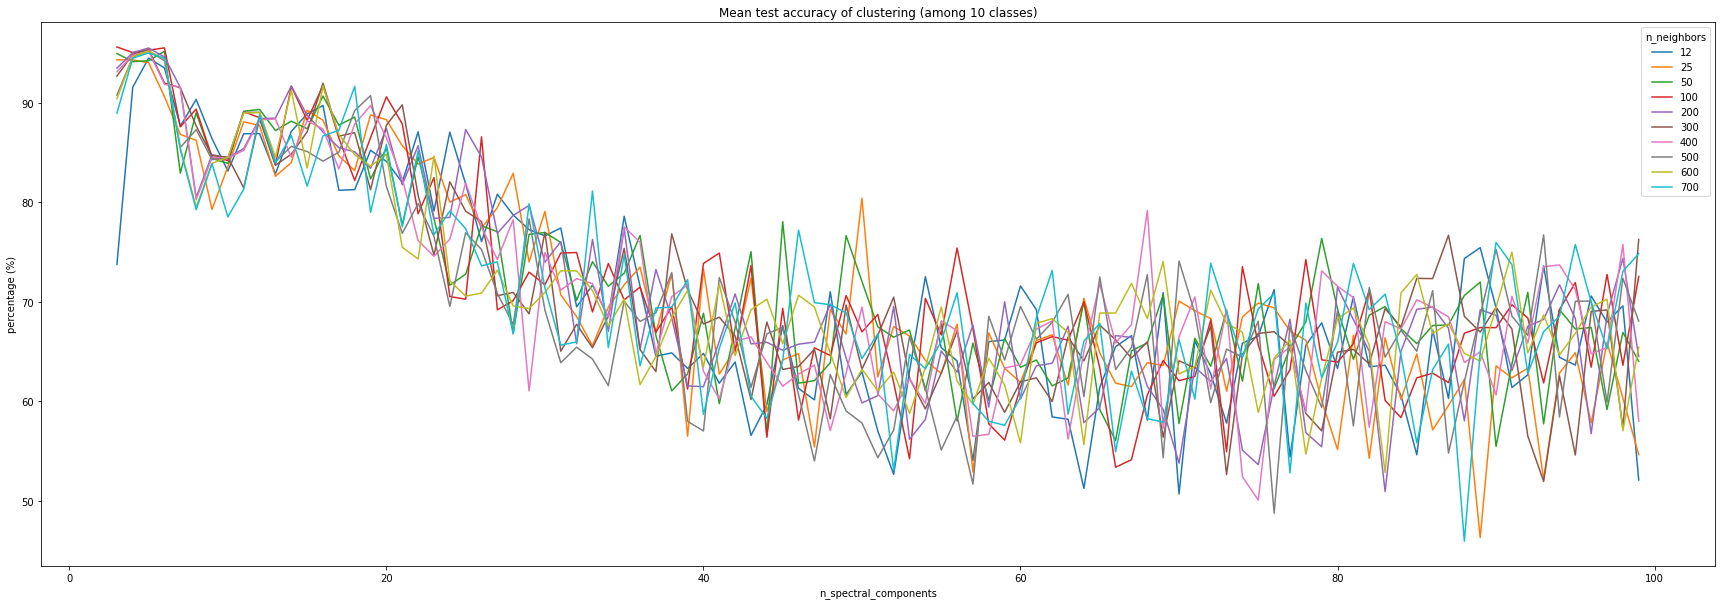

In [13]:
p_mean_arr = np.array(p_mean_list).reshape(len(n_neighbors_list), 
                                           spectral_components_list.shape[0])
plt.figure(figsize=(30, 10))
for i, n_neighbors in enumerate(n_neighbors_list):
  plt.plot(spectral_components_list, p_mean_arr[i, :], label=n_neighbors)
plt.xlabel("n_spectral_components")
plt.ylabel("percentage (%)")
plt.title("Mean test accuracy of clustering (among 10 classes)")
plt.legend(title="n_neighbors")
plt.show()

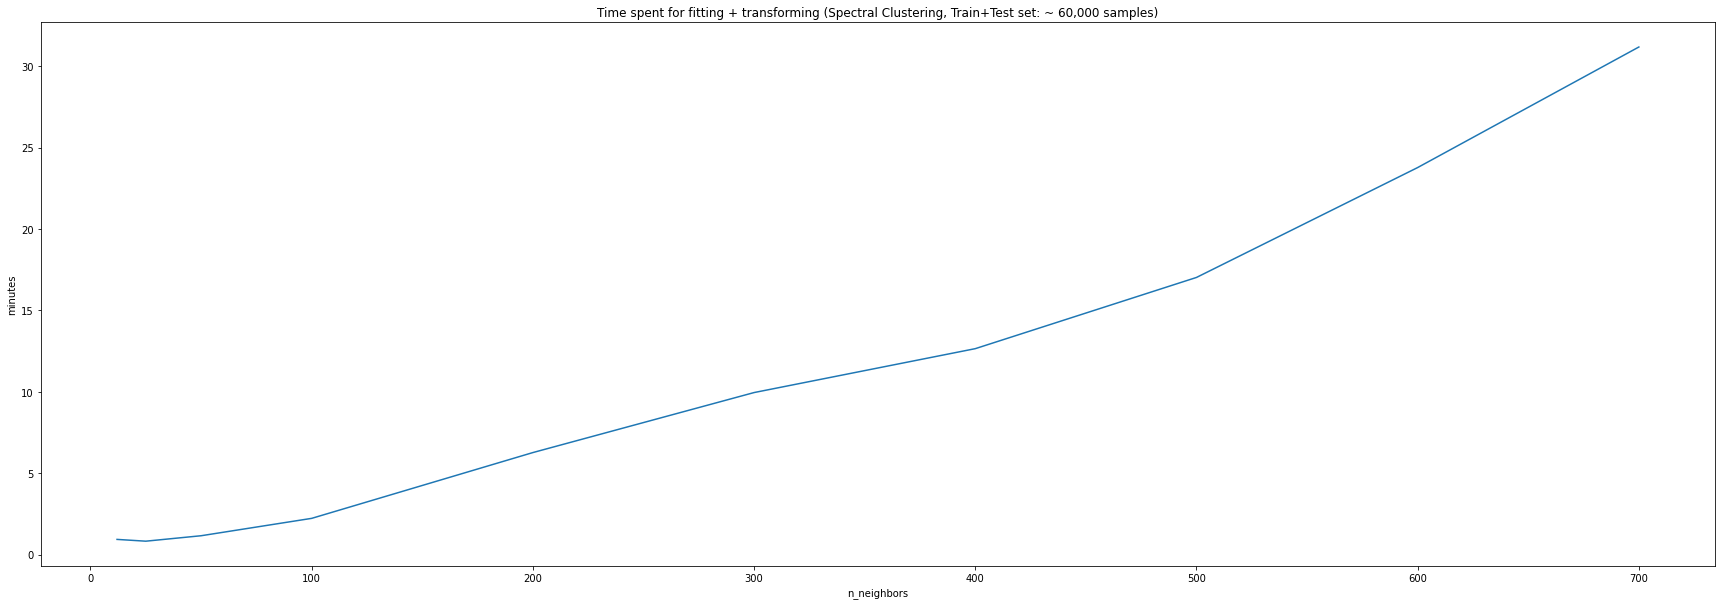

In [15]:
dt_spectral_arr = np.array(dt_spectral_list)
n_neighbors_arr = np.array(n_neighbors_list)
plt.figure(figsize=(30, 10))
plt.plot(n_neighbors_arr, dt_spectral_arr/60)
plt.xlabel("n_neighbors")
plt.ylabel("minutes")
plt.title("Time spent for fitting + transforming (Spectral Clustering, Train+Test set: ~ 60,000 samples)")
plt.show()

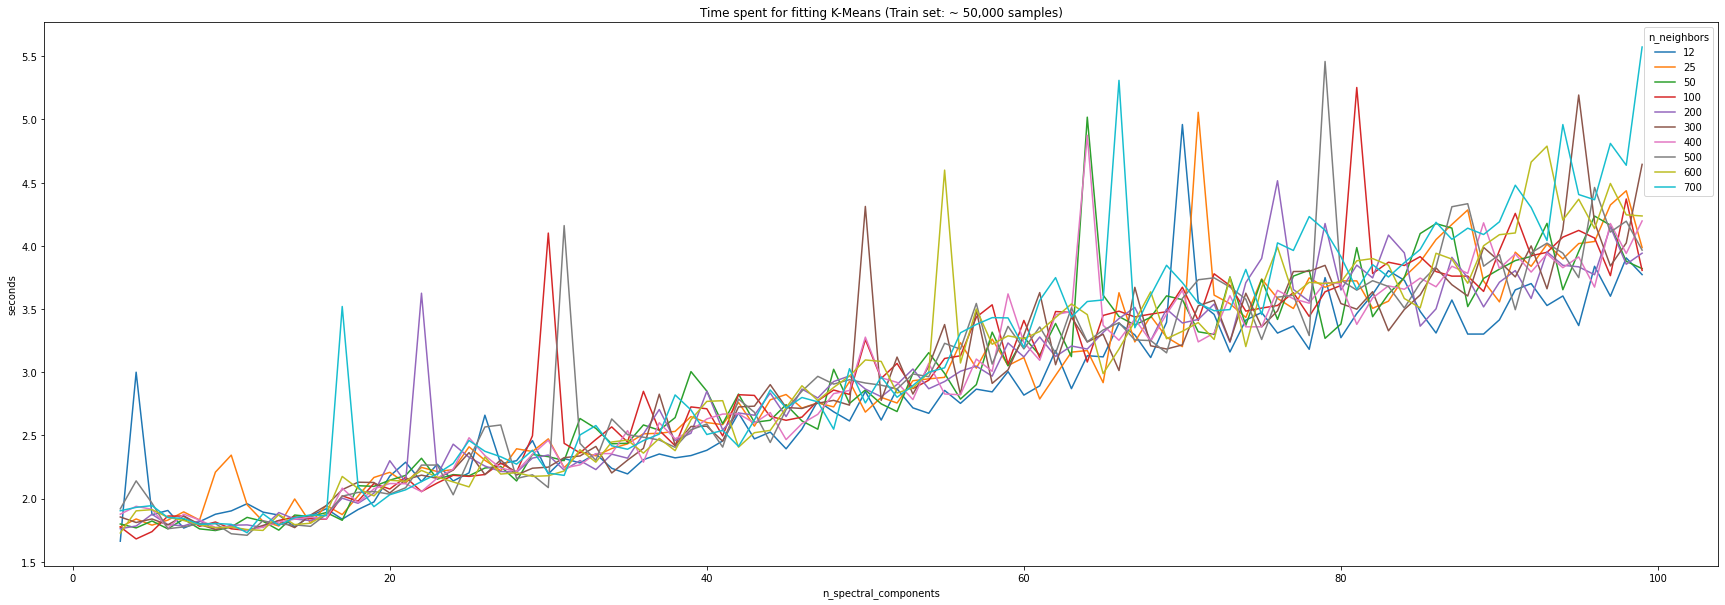

In [16]:
dt_kmeans_arr = np.array(dt_kmeans_list).reshape(len(n_neighbors_list), 
                                                 spectral_components_list.shape[0])
plt.figure(figsize=(30, 10))
for i, n_neighbors in enumerate(n_neighbors_list):
  plt.plot(spectral_components_list, dt_kmeans_arr[i, :], label=n_neighbors)
plt.xlabel("n_spectral_components")
plt.ylabel("seconds")
plt.title("Time spent for fitting K-Means (Train set: ~ 50,000 samples)")
plt.legend(title="n_neighbors")
plt.show()

In [17]:
row_max = np.where(p_mean_arr == p_mean_arr.max())[0][0]
col_max = np.where(p_mean_arr == p_mean_arr.max())[1][0]

print(f"Row: {row_max}, Column: {col_max}")

Row: 3, Column: 0


In [18]:
print(f"Best Accuracy = {p_mean_arr[row_max, col_max]}% --> n_neighbors = {n_neighbors_list[row_max]}, n_spectral_components = {spectral_components_list[col_max]}")

Best Accuracy = 95.604% --> n_neighbors = 100, n_spectral_components = 3


In [19]:
p_mean_arr.shape

(10, 97)

In [25]:
n_neighbors = n_neighbors_list[row_max]
n_components = spectral_components_list[col_max]
KN = kneighbors_graph(X_tsne, n_neighbors=n_neighbors, mode='connectivity', include_self=True)
V = spectral_embedding(KN, n_components=n_components, norm_laplacian=False, drop_first=False)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


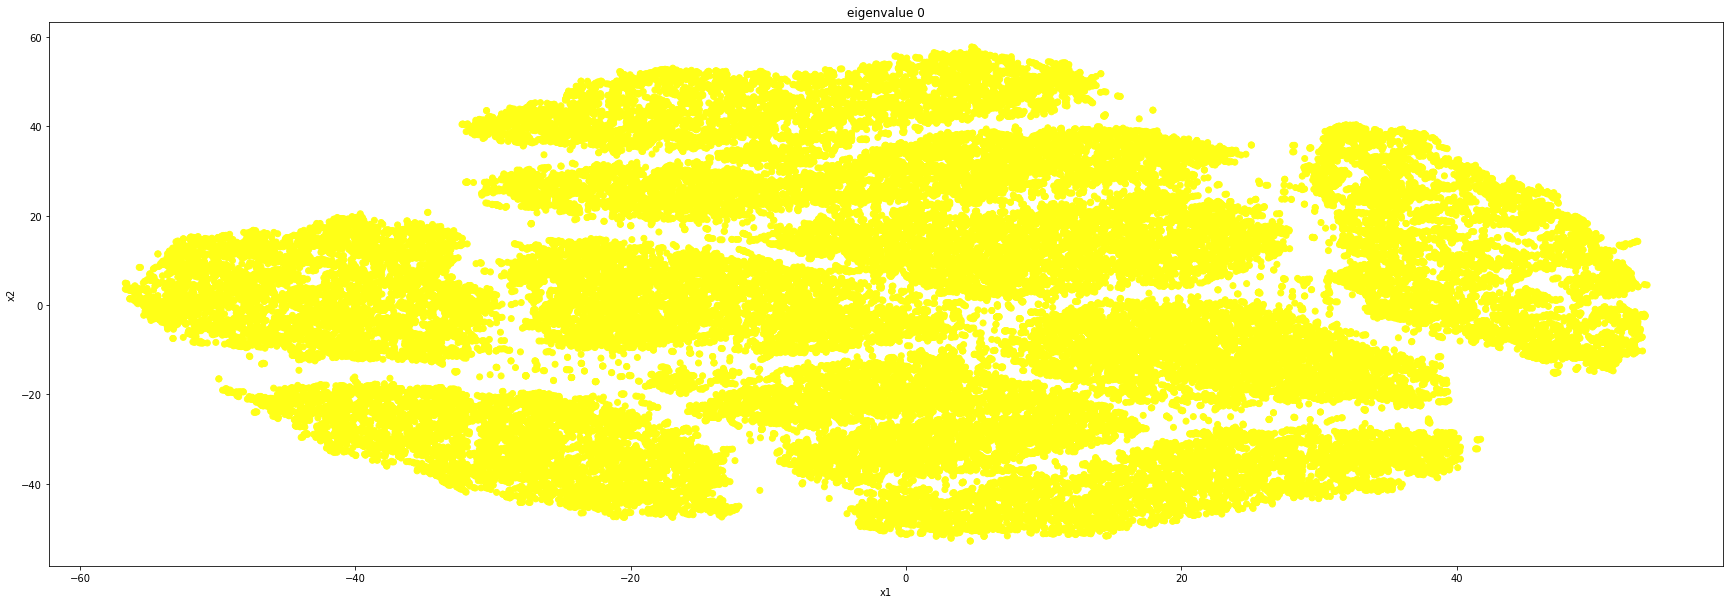

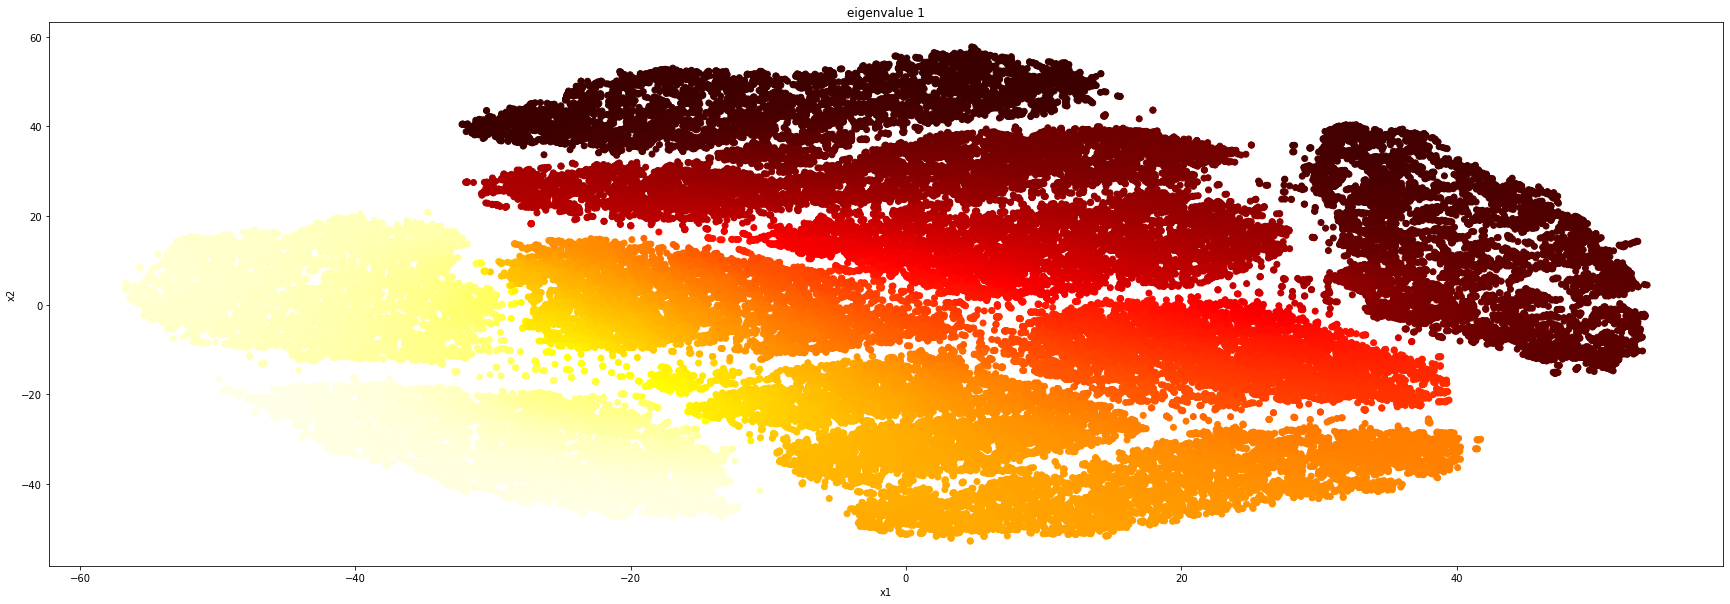

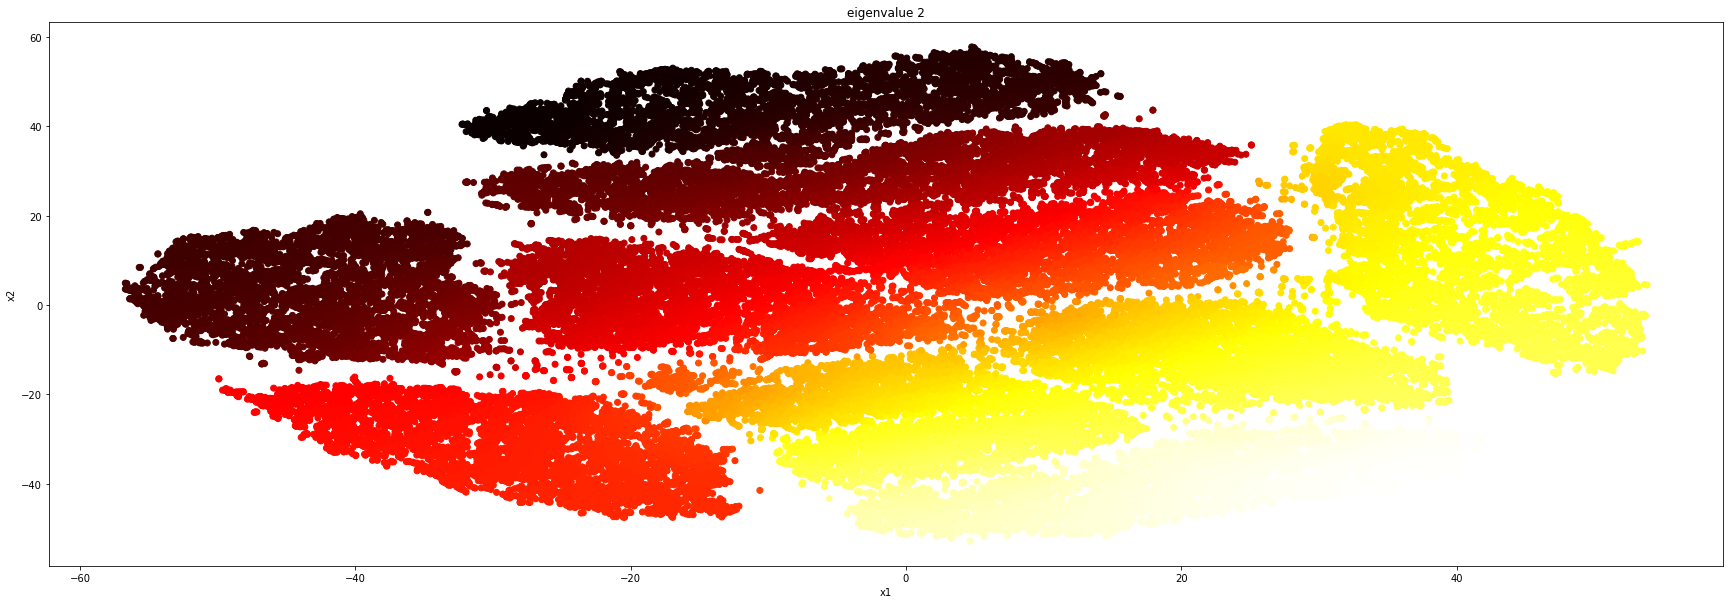

In [30]:
Z = (255 * (V - V.min()) / np.ptp(V)).astype(int)  
for n in range(spectral_components_list[col_max]):
  plt.figure(figsize=(30, 10))
  cmap = plt.cm.hot
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], color=cmap(Z[:, n]))
  plt.xlabel("x1"), plt.ylabel("x2")
  plt.title(f"eigenvalue {n}")
  sm = plt.cm.ScalarMappable(cmap=cmap)
  plt.show()

## Spectral clustering

In [32]:
n_neighbors = n_neighbors_list[row_max]
n_components = 100
KN = kneighbors_graph(X_tsne, n_neighbors=n_neighbors, mode='connectivity', include_self=True)
V = spectral_embedding(KN, n_components=n_components, norm_laplacian=False, drop_first=False)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


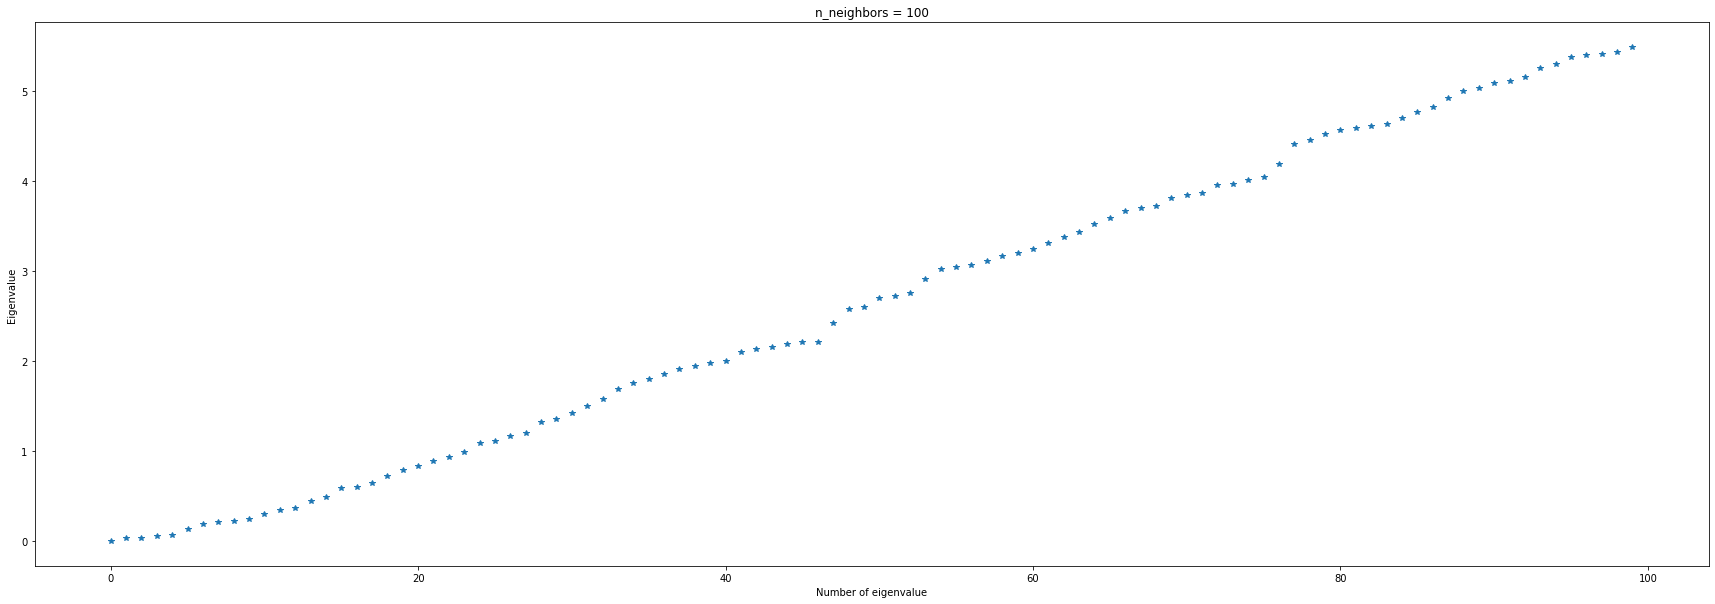

In [34]:
sim_matrix_train = (KN + KN.T)/2
D_train = sparse.diags(np.array(sparse.csr_matrix.sum(sim_matrix_train, axis=1)).flatten(), offsets=0)
L_train = D_train - sim_matrix_train

eigvals_train = list()
for n in range(n_components):
  v = V[:, n]
  lambda_v = sparse.csr_matrix.dot(L_train, v)
  eigval_train = np.divide(lambda_v, v).mean()
  eigvals_train.append(eigval_train)

plt.figure(figsize=(30, 10))
plt.plot(eigvals_train, "*")
plt.title(f"n_neighbors = {n_neighbors}")
plt.xlabel("Number of eigenvalue")
plt.ylabel("Eigenvalue")
plt.show()

## K-Means

In [ ]:
n_clusters = 10
k_means = KMeans(n_clusters=n_clusters, random_state=0, max_iter=1000)
k_means.fit(V_train[:, 1:])
y_preds = k_means.predict(V_test[:, 1:])

In [ ]:
y_preds

array([9, 6, 4, ..., 0, 5, 3], dtype=int32)

In [ ]:
p_list = list()
for true_class in range(10):
  y_preds_c = k_means.predict(V_test[:, 1:][y_test == true_class])
  s = pd.Series(y_preds_c).value_counts()
  p = float("{:.2f}".format(100 * s.max() / s.sum()))
  p_list.append(p)
  print(f"True Class: {true_class} --> {p}%")
p_mean = np.array(p_list).mean()
print("==============================")
print(f"Mean percentage = {p_mean}%")
print("==============================")

True Class: 0 --> 97.96%
True Class: 1 --> 70.48%
True Class: 2 --> 88.47%
True Class: 3 --> 61.68%
True Class: 4 --> 55.4%
True Class: 5 --> 94.96%
True Class: 6 --> 80.17%
True Class: 7 --> 94.16%
True Class: 8 --> 53.39%
True Class: 9 --> 71.26%
Mean percentage = 76.79299999999999%


## Try different number of clusters

In [35]:
n_neighbors = n_neighbors_list[row_max]
n_components = spectral_components_list[col_max]
n_clusters_list = [2, 3, 4, 5, 10, 15, 20, 25, 30]

sc_plus_kmeans = MySpectralPlusKMeans()
V, dt_spectral = sc_plus_kmeans.fit_transform(X_tsne, 
                                              n_neighbors=n_neighbors, 
                                              spectral_components=n_components)

V_train = V[:X_train.shape[0], :n_components]
V_test = V[X_train.shape[0]:, :n_components]

for n_clusters in n_clusters_list:
  dt_kmeans = sc_plus_kmeans.fit_kmeans(V_train, n_clusters=n_clusters)
  y_preds = sc_plus_kmeans.predict(V_test)
  plt.figure(figsize=(30, 10))
  plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_preds)
  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.title(f"n_neighbors = {n_neighbors}, spectral_components = {n_components} (n_clusters = {n_clusters})")
  plt.show()

Output hidden; open in https://colab.research.google.com to view.